In [ ]:
!pip install facenet-pytorch
!pip install Pillow
!pip install -q tensorflow==2.0.0
!pip install adversarial-robustness-toolbox[all]
!pip install matplotlib

# Inizialization

In [1]:
# LIBRERIE UTILI
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt
import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


In [2]:
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from art.estimators.classification import PyTorchClassifier
resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True



fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    return tns

model = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.

In [3]:
from torchvision import transforms
from PIL import Image

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    return tns

In [4]:
# Import attack
from torch.nn import CrossEntropyLoss

from art.estimators.classification import PyTorchClassifier

#Impostare l'input shape
classifier = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.


# DeepFool generic Attack on all test set

In [8]:
from art.attacks.evasion import DeepFool
import os
import re

dataset_dir = "test_set_cropped/" 
eps_range = [0.00002, 0.00005, 0.00007, 0.0002, 0.0005, 0.0007, 0.002, 0.005, 0.007, 0.01] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.

max_iter = [2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
 


accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_predictions = 0
total_images = 0
print("Inizio Attacco DeepFool NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for eps in eps_range:   
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = DeepFool(classifier=classifier, epsilon=eps, max_iter=max_iter[i])
            
            print("**** Attacco con eps:{} ****".format(eps))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1

                    accuracy = correct_predictions/total_images
                    print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(eps,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(eps,final_accuracy))

            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_range) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_range) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")


Inizio Attacco DeepFool NON-TARGETED
**** Attacco con max_iter 2 **** 
**** Attacco con eps:2e-05 ****


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Michael_Phelps
Predetto  Rick_Perry con probabilità 11.471315383911133 e con perturbazione 0.0008443586993962526
Adversarial Sample misclassificati correttamente attuale: 100.0%


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Paola_Barale
Predetto  Ewa_Kasprzyk con probabilità 11.612679481506348 e con perturbazione 0.001051923492923379
Adversarial Sample misclassificati correttamente attuale: 100.0%


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Louis_Gossett_Jr. con probabilità 11.520484924316406 e con perturbazione 0.001424698974005878
Adversarial Sample misclassificati correttamente attuale: 100.0%


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Etichetta corretta: Max_Pezzali
Predetto  Max_Pezzali con probabilità 8.32771110534668 e con perturbazione 0.0026498788502067327
Adversarial Sample misclassificati correttamente attuale: 75.0%


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Trey_Songz con probabilità 10.14343547821045 e con perturbazione 0.002139967866241932
Adversarial Sample misclassificati correttamente attuale: 80.0%


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Ashley_Scott
Predetto  Cerys_Matthews con probabilità 12.899141311645508 e con perturbazione 0.0013362328754737973
Adversarial Sample misclassificati correttamente attuale: 83.33333333333334%


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Robert_Berić con probabilità 10.147896766662598 e con perturbazione 0.0011691042454913259
Adversarial Sample misclassificati correttamente attuale: 85.71428571428572%


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Etichetta corretta: Michael_Phelps
Predetto  Michael_Boogerd con probabilità 10.548789978027344 e con perturbazione 0.002262591617181897
Adversarial Sample misclassificati correttamente attuale: 87.5%


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 10.24135971069336 e con perturbazione 0.001043263473547995
Adversarial Sample misclassificati correttamente attuale: 77.77777777777777%


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(perturbation_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(max_iter), np.array(accuracy_for_max_iter = []), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('max_iter')
plt.ylabel('Accuracy mean')
plt.show()

# Single sample attack Deepfool

In [22]:
from art.attacks.evasion import DeepFool

epsilon = 10
max_iter = 10

attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter)

In [23]:
test_img = load_image("test_set_cropped/Antonio_Cassano_8_face_0.jpg")

test_img = test_img.unsqueeze(0)
test_img = test_img.numpy()
test_images_adv = attack.generate(test_img)
model_predictions = model.predict(test_images_adv)
predicted_label = LABELS[np.array(model_predictions[0].argmax())]


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


In [24]:
print(predicted_label)

 Alfie_Allen


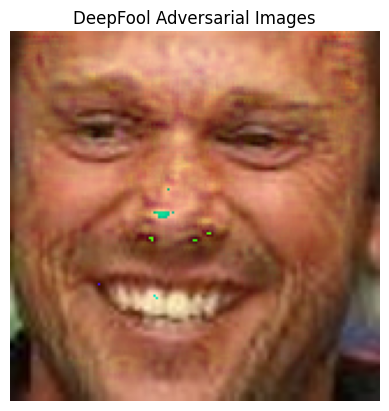

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Supponiamo che test_images_adv sia un array numpy con forma (1, 3, 160, 160)
# Rimuoviamo la dimensione batch extra
test_images_adv = np.squeeze(test_images_adv, axis=0)  # Ora la forma è (3, 160, 160)

# Trasponiamo l'array per convertirlo nel formato channels-last
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))  # Ora la forma è (160, 160, 3)

# Convertiamo in tipo uint8 se necessario
if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizziamo l'immagine con Matplotlib
plt.imshow(test_images_adv)
plt.title("DeepFool Adversarial Images")
plt.axis('off')  # Disabilita gli assi
plt.show()